In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean, cosine as cosine_distance
from scipy.stats import zscore, percentileofscore, pearsonr
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
df = pd.read_csv('../../data/preprocessed/resources_and_human_capital_dataset.csv')
print(f"\n✅ Loaded: {df.shape[0]} countries, {df.shape[1]} indicators")

if 'Algeria' not in df['Country'].values:
    print("❌ ERROR: Algeria not found!")
    exit()
else:
    print("🇩🇿 Algeria found in dataset!")

# Preprocessing
countries = df['Country'].copy()
numeric_df = df.select_dtypes(include=[np.number])
print(f"\n📊 Numeric indicators: {numeric_df.shape[1]}")
print(f"   Missing values: {numeric_df.isnull().sum().sum()} ({numeric_df.isnull().sum().sum()/(numeric_df.shape[0]*numeric_df.shape[1])*100:.1f}%)")

numeric_df_filled = numeric_df.fillna(numeric_df.median())
df_processed = pd.concat([countries, numeric_df_filled], axis=1)

algeria_data = df_processed[df_processed['Country'] == 'Algeria'].iloc[0]
algeria_numeric = algeria_data.drop('Country')

print(f"🇩🇿 Algeria data: {len(algeria_numeric)} indicators extracted")


✅ Loaded: 232 countries, 86 indicators
🇩🇿 Algeria found in dataset!

📊 Numeric indicators: 85
   Missing values: 3666 (18.6%)
🇩🇿 Algeria data: 85 indicators extracted


# TECHNIQUE 1: PERCENTILE RANKING


🏆 TOP 10 STRONGEST INDICATORS:
                                                                               Indicator  Percentile
                                Energy_Energy use_Fossil fuel_% of total energy use_1990   98.922414
Edu_Completion_Students at lowest proficiency on PISA_Mathematics_% of 15 year-olds_2018   98.706897
                                         NatResource_GDP_Natural gas rents_% of GDP_2021   96.982759
    Edu_Completion_Students at lowest proficiency on PISA_Science_% of 15 year-olds_2018   95.474138
                                                 NatResource_GDP_Oil rents_% of GDP_2021   93.103448
                             NatResource_GDP_Total natural resources rents_% of GDP_2021   91.810345
                                                      Surface area_sq. km thousands_2024   90.948276
                                                       Rural_Env_Land area (sq. km)_2021   90.948276
               Energy_Energy production_Total_million metri

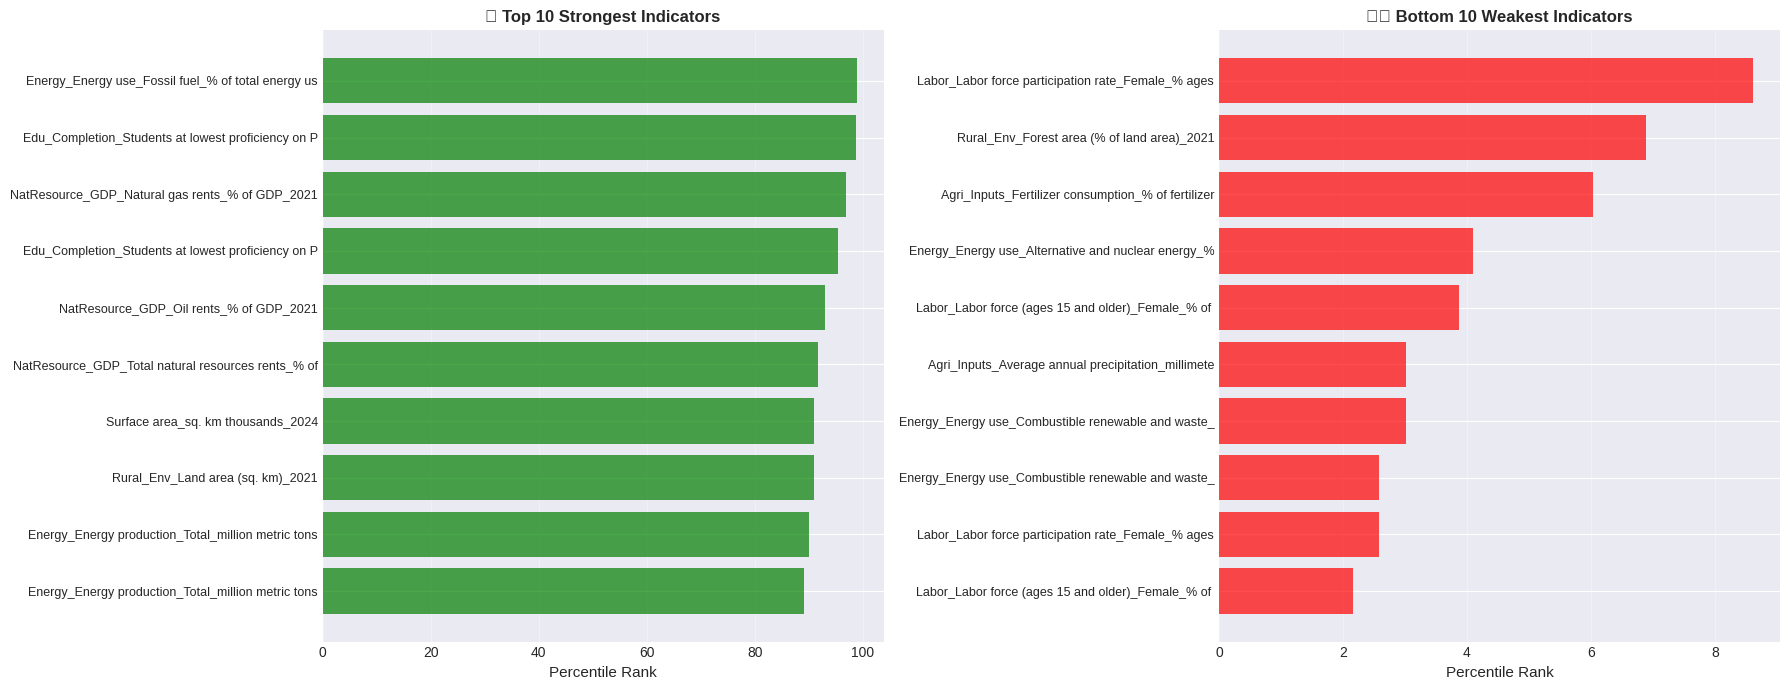

In [ ]:
percentile_ranks = {col: percentileofscore(numeric_df_filled[col], algeria_numeric[col]) 
                    for col in numeric_df_filled.columns}
percentile_df = pd.DataFrame(list(percentile_ranks.items()), 
                              columns=['Indicator', 'Percentile']).sort_values('Percentile', ascending=False)

print(f"\n🏆 TOP 10 STRONGEST INDICATORS:")
print(percentile_df.head(10).to_string(index=False))
print(f"\n⚠️ BOTTOM 10 WEAKEST INDICATORS:")
print(percentile_df.tail(10).to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
top_10 = percentile_df.head(10)
ax1.barh(range(len(top_10)), top_10['Percentile'], color='green', alpha=0.7)
ax1.set_yticks(range(len(top_10)))
ax1.set_yticklabels([ind[:50] for ind in top_10['Indicator']], fontsize=9)
ax1.set_xlabel('Percentile Rank', fontsize=11)
ax1.set_title('🏆 Top 10 Strongest Indicators', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

bottom_10 = percentile_df.tail(10)
ax2.barh(range(len(bottom_10)), bottom_10['Percentile'], color='red', alpha=0.7)
ax2.set_yticks(range(len(bottom_10)))
ax2.set_yticklabels([ind[:50] for ind in bottom_10['Indicator']], fontsize=9)
ax2.set_xlabel('Percentile Rank', fontsize=11)
ax2.set_title('⚠️ Bottom 10 Weakest Indicators', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../../pictures/algeria_and_counties_resources_and_human_capital_comparison.png')

# TECHNIQUE 2: EUCLIDEAN DISTANCE


🌍 TOP 15 MOST SIMILAR COUNTRIES (Euclidean Distance):
                                          Country  Distance
                               Iran, Islamic Rep.  5.947403
                                          Morocco  6.299786
                                          Tunisia  6.536336
                                           Jordan  6.832932
                                             Iraq  7.965670
                                 Egypt, Arab Rep.  7.970412
                               West Bank and Gaza  8.185292
                                             Oman  8.368468
Middle East, North Africa, Afghanistan & Pakistan  8.377896
                                       Uzbekistan  8.438326
                                           Mexico  8.495656
                                           Kosovo  8.528098
                                        Gibraltar  8.971609
                       Middle East & North Africa  9.050501
                           British Virgin Isl

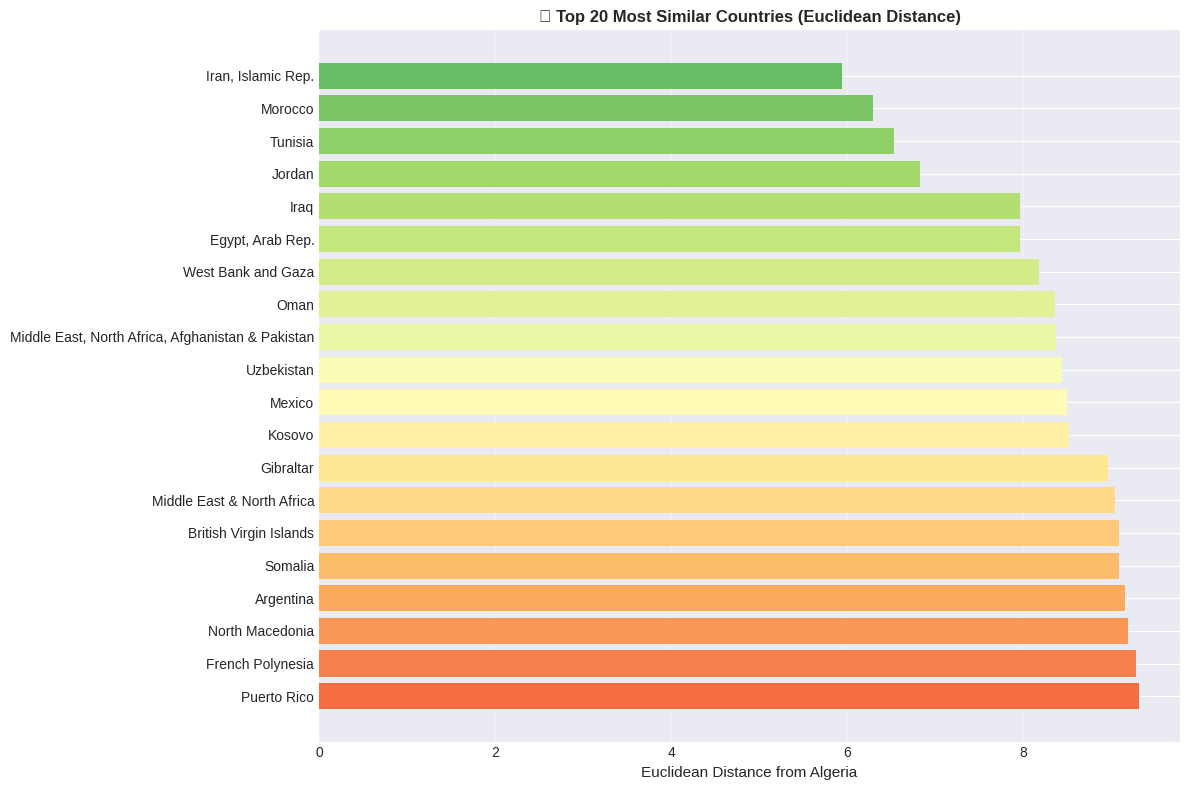

In [5]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df_filled)
algeria_idx = df_processed[df_processed['Country'] == 'Algeria'].index[0]
algeria_scaled = scaled_data[algeria_idx]

euclidean_distances = {countries.iloc[idx]: euclidean(algeria_scaled, scaled_data[idx])
                       for idx in range(len(countries)) if countries.iloc[idx] != 'Algeria'}
euclidean_df = pd.DataFrame(list(euclidean_distances.items()), 
                            columns=['Country', 'Distance']).sort_values('Distance')

print(f"\n🌍 TOP 15 MOST SIMILAR COUNTRIES (Euclidean Distance):")
print(euclidean_df.head(15).to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 8))
top_20 = euclidean_df.head(20)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top_20)))
ax.barh(range(len(top_20)), top_20['Distance'], color=colors)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['Country'], fontsize=10)
ax.set_xlabel('Euclidean Distance from Algeria', fontsize=11)
ax.set_title('🌍 Top 20 Most Similar Countries (Euclidean Distance)', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()

# TECHNIQUE 3: COSINE SIMILARITY


🔍 TOP 15 MOST SIMILAR COUNTRIES (Cosine Similarity):
                                          Country  Similarity
                               Iran, Islamic Rep.    0.744653
                                          Morocco    0.687457
                                           Jordan    0.661381
                                             Iraq    0.660272
                                          Tunisia    0.651497
                                             Oman    0.583951
                                 Egypt, Arab Rep.    0.535554
                                            Libya    0.517553
                                     Saudi Arabia    0.502055
                                      Yemen, Rep.    0.487459
Middle East, North Africa, Afghanistan & Pakistan    0.467361
                               West Bank and Gaza    0.439123
                                          Lebanon    0.434667
                                            Qatar    0.430178
                

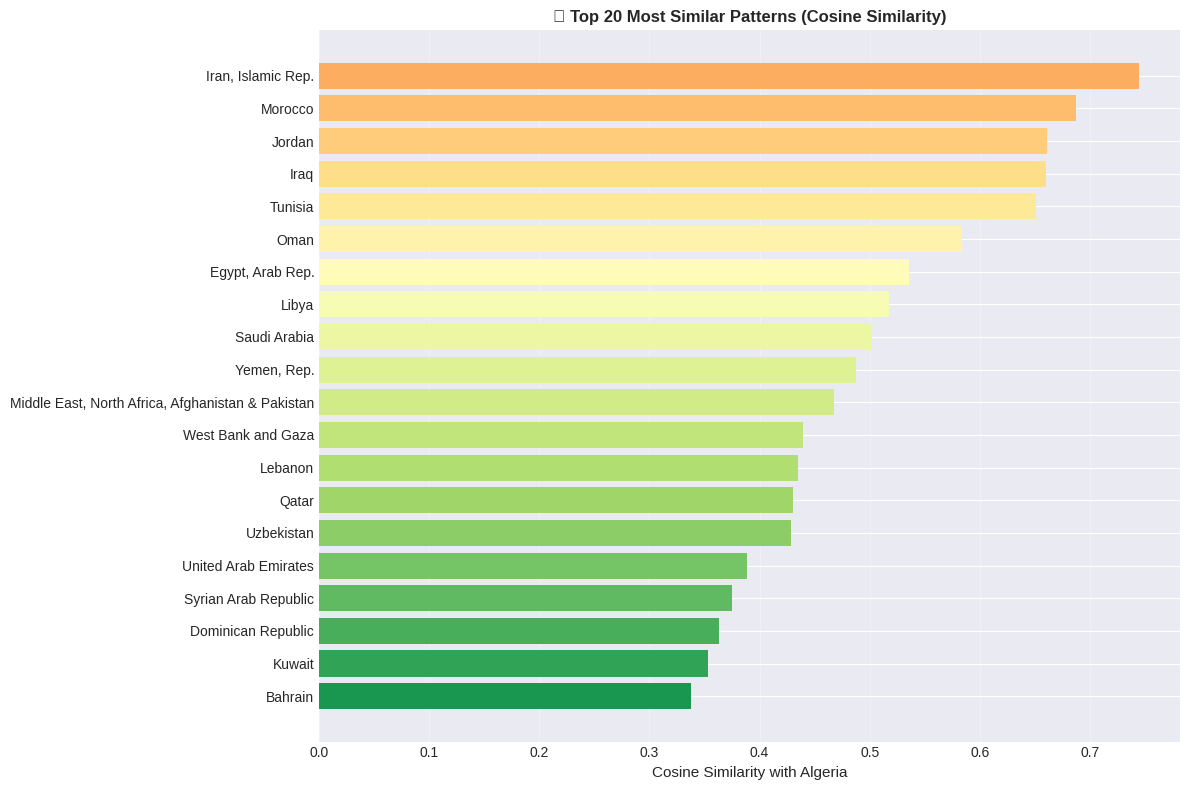

In [6]:
cosine_similarities = {}
for idx in range(len(countries)):
    if countries.iloc[idx] != 'Algeria':
        algeria_vec = algeria_scaled
        country_vec = scaled_data[idx]
        
        if (not np.any(np.isnan(algeria_vec)) and 
            not np.any(np.isnan(country_vec)) and
            not np.any(np.isinf(algeria_vec)) and 
            not np.any(np.isinf(country_vec))):
            if np.any(algeria_vec != 0) and np.any(country_vec != 0):
                try:
                    similarity = 1 - cosine_distance(algeria_vec, country_vec)
                    if not np.isnan(similarity):
                        cosine_similarities[countries.iloc[idx]] = similarity
                except:
                    pass

cosine_df = pd.DataFrame(list(cosine_similarities.items()), 
                         columns=['Country', 'Similarity']).sort_values('Similarity', ascending=False)

print(f"\n🔍 TOP 15 MOST SIMILAR COUNTRIES (Cosine Similarity):")
if len(cosine_df) > 0:
    print(cosine_df.head(15).to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(12, 8))
    top_20 = cosine_df.head(20)
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_20)))
    ax.barh(range(len(top_20)), top_20['Similarity'], color=colors)
    ax.set_yticks(range(len(top_20)))
    ax.set_yticklabels(top_20['Country'], fontsize=10)
    ax.set_xlabel('Cosine Similarity with Algeria', fontsize=11)
    ax.set_title('🔍 Top 20 Most Similar Patterns (Cosine Similarity)', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()

# TECHNIQUE 4: Z-SCORE PROFILING


🚀 EXCEPTIONAL HIGH (Z-score > 2): 2 indicators
Edu_Completion_Students at lowest proficiency on PISA_Mathematics_% of 15 year-olds_2018    3.771429
NatResource_GDP_Natural gas rents_% of GDP_2021                                             2.558637
dtype: float64

⚠️ EXCEPTIONAL LOW (Z-score < -2): 3 indicators
Labor_Labor force (ages 15 and older)_Female_% of labor force_2021     -2.939924
Labor_Labor force (ages 15 and older)_Female_% of labor force_2015     -2.855869
Labor_Labor force participation rate_Female_% ages 15 and older_2015   -2.574248
dtype: float64

✅ NORMAL RANGE (-2 to +2): 80 indicators


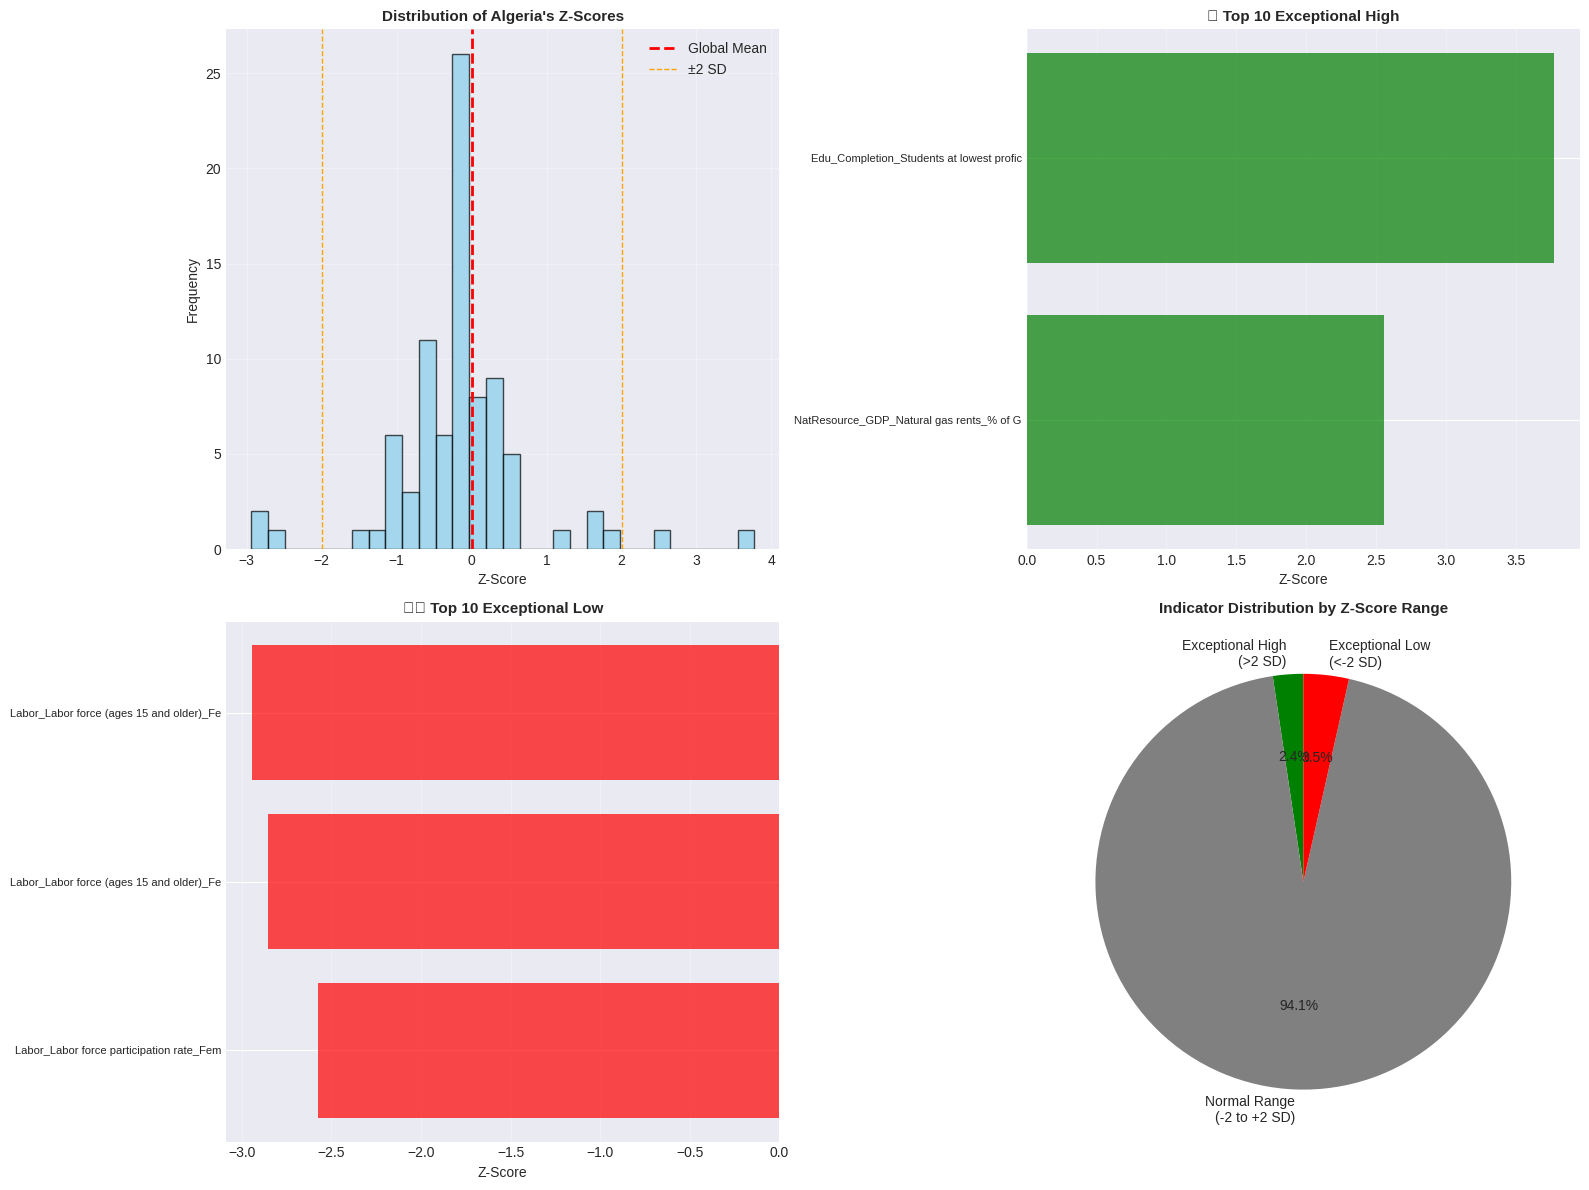

In [7]:
z_scores = zscore(numeric_df_filled, nan_policy='omit')
algeria_z = z_scores[algeria_idx]

exceptional_high = pd.Series(algeria_z[algeria_z > 2], 
                             index=numeric_df_filled.columns[algeria_z > 2]).sort_values(ascending=False)
exceptional_low = pd.Series(algeria_z[algeria_z < -2], 
                           index=numeric_df_filled.columns[algeria_z < -2]).sort_values()
normal_range = algeria_z[(algeria_z >= -2) & (algeria_z <= 2)]

print(f"\n🚀 EXCEPTIONAL HIGH (Z-score > 2): {len(exceptional_high)} indicators")
if len(exceptional_high) > 0:
    print(exceptional_high.head(10))

print(f"\n⚠️ EXCEPTIONAL LOW (Z-score < -2): {len(exceptional_low)} indicators")
if len(exceptional_low) > 0:
    print(exceptional_low.head(10))

print(f"\n✅ NORMAL RANGE (-2 to +2): {len(normal_range)} indicators")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribution
axes[0, 0].hist(algeria_z, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Global Mean')
axes[0, 0].axvline(x=2, color='orange', linestyle='--', linewidth=1, label='±2 SD')
axes[0, 0].axvline(x=-2, color='orange', linestyle='--', linewidth=1)
axes[0, 0].set_xlabel('Z-Score', fontsize=10)
axes[0, 0].set_ylabel('Frequency', fontsize=10)
axes[0, 0].set_title('Distribution of Algeria\'s Z-Scores', fontsize=11, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Top exceptional high
if len(exceptional_high) > 0:
    top = exceptional_high.head(10)
    axes[0, 1].barh(range(len(top)), top.values, color='green', alpha=0.7)
    axes[0, 1].set_yticks(range(len(top)))
    axes[0, 1].set_yticklabels([i[:40] for i in top.index], fontsize=8)
    axes[0, 1].set_xlabel('Z-Score', fontsize=10)
    axes[0, 1].set_title('🚀 Top 10 Exceptional High', fontsize=11, fontweight='bold')
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(axis='x', alpha=0.3)

# Bottom exceptional low
if len(exceptional_low) > 0:
    bottom = exceptional_low.head(10)
    axes[1, 0].barh(range(len(bottom)), bottom.values, color='red', alpha=0.7)
    axes[1, 0].set_yticks(range(len(bottom)))
    axes[1, 0].set_yticklabels([i[:40] for i in bottom.index], fontsize=8)
    axes[1, 0].set_xlabel('Z-Score', fontsize=10)
    axes[1, 0].set_title('⚠️ Top 10 Exceptional Low', fontsize=11, fontweight='bold')
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(axis='x', alpha=0.3)

# Category breakdown
categories = ['Exceptional High\n(>2 SD)', 'Normal Range\n(-2 to +2 SD)', 'Exceptional Low\n(<-2 SD)']
counts = [len(exceptional_high), len(normal_range), len(exceptional_low)]
colors_pie = ['green', 'gray', 'red']
axes[1, 1].pie(counts, labels=categories, autopct='%1.1f%%', colors=colors_pie, 
               startangle=90, textprops={'fontsize': 10})
axes[1, 1].set_title('Indicator Distribution by Z-Score Range', fontsize=11, fontweight='bold')

plt.tight_layout()

# TECHNIQUE 5: PEER GROUP IDENTIFICATION


🔑 Using 6 key indicators for peer grouping:
   • Population_millions_2024
   • Population density_people per sq. km_2024
   • Rural_Env_Forest area (% of land area)_2021
   • Energy_Energy use_per capita_kilograms of oil equivalent_2015
   • Labor_Labor force participation rate_Male_% ages 15 and older_2021
   • Edu_Completion_Adult literacy rate_Male_% ages 15 and older_2016-23

👥 FOUND 107 PEER COUNTRIES (within 25% range on ≥50% of key indicators):
               Country  Match_Ratio  Matching_Indicators
             Argentina     0.666667                    4
                Bhutan     0.666667                    4
                Belize     0.666667                    4
      Papua New Guinea     0.666667                    4
          Saudi Arabia     0.666667                    4
            Uzbekistan     0.666667                    4
               Uruguay     0.666667                    4
         New Caledonia     0.666667                    4
               Andorra     0.5

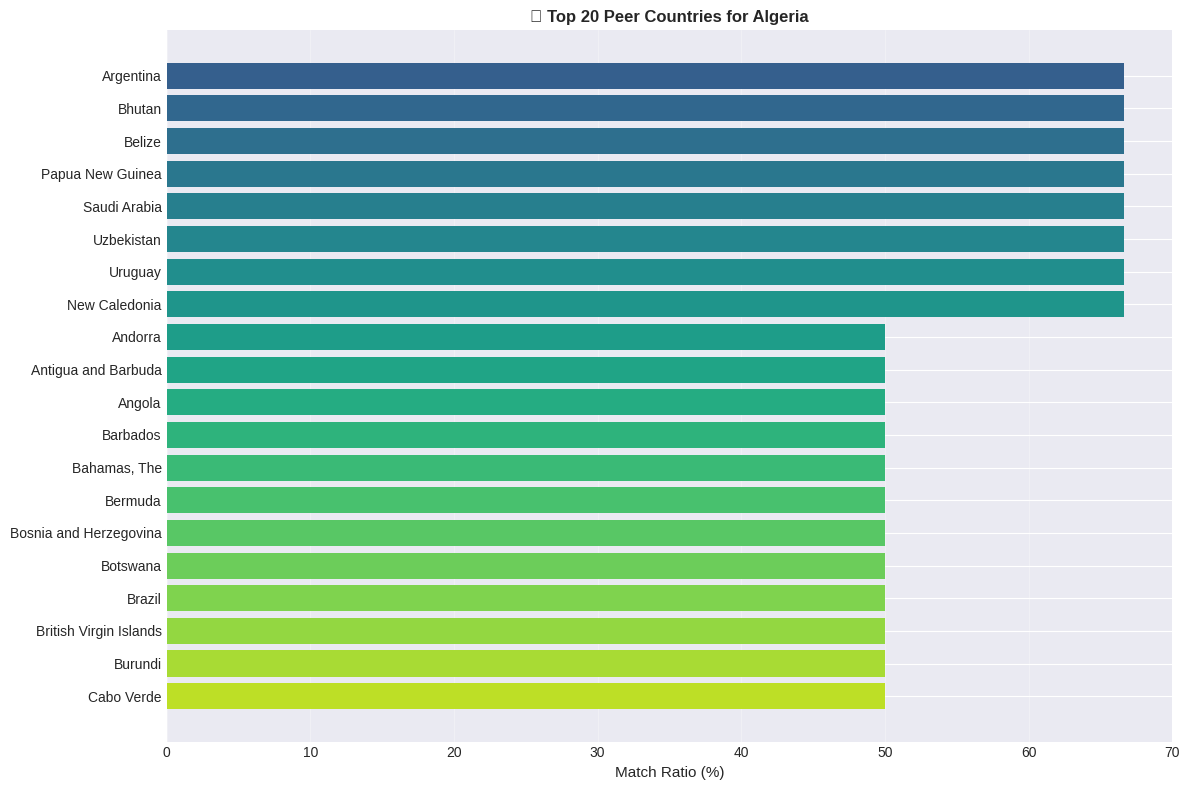

In [8]:

key_indicators = [
    'Population_millions_2024',
    'Population density_people per sq. km_2024',
    'Rural_Env_Forest area (% of land area)_2021',
    'Energy_Energy use_per capita_kilograms of oil equivalent_2015',
    'Labor_Labor force participation rate_Male_% ages 15 and older_2021',
    'Edu_Completion_Adult literacy rate_Male_% ages 15 and older_2016-23'
]

available_key = [col for col in key_indicators if col in df_processed.columns]
print(f"\n🔑 Using {len(available_key)} key indicators for peer grouping:")
for ind in available_key:
    print(f"   • {ind}")

peers = []
for idx, row in df_processed.iterrows():
    if row['Country'] == 'Algeria':
        continue
    
    match_count = 0
    for col in available_key:
        algeria_val = algeria_numeric[col]
        country_val = row[col]
        
        if pd.notna(algeria_val) and pd.notna(country_val):
            if algeria_val != 0:
                percent_diff = abs((country_val - algeria_val) / algeria_val)
                if percent_diff <= 0.25:  # Within 25%
                    match_count += 1
            else:
                if abs(country_val) <= 0.01:
                    match_count += 1
    
    match_ratio = match_count / len(available_key)
    if match_ratio >= 0.5:  # At least 50% match
        peers.append({
            'Country': row['Country'],
            'Match_Ratio': match_ratio,
            'Matching_Indicators': match_count
        })

peers_df = pd.DataFrame(peers).sort_values('Match_Ratio', ascending=False)

print(f"\n👥 FOUND {len(peers_df)} PEER COUNTRIES (within 25% range on ≥50% of key indicators):")
if len(peers_df) > 0:
    print(peers_df.head(20).to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(12, 8))
    top_20 = peers_df.head(20)
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_20)))
    ax.barh(range(len(top_20)), top_20['Match_Ratio']*100, color=colors)
    ax.set_yticks(range(len(top_20)))
    ax.set_yticklabels(top_20['Country'], fontsize=10)
    ax.set_xlabel('Match Ratio (%)', fontsize=11)
    ax.set_title('👥 Top 20 Peer Countries for Algeria', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
else:
    print("⚠️ No peer countries found with current criteria")


# TECHNIQUE 6: CORRELATION-BASED SIMILARITY


🔗 TOP 15 COUNTRIES WITH HIGHEST CORRELATION:
                  Country  Correlation
              High income     0.999860
                 Mongolia     0.999830
                   Canada     0.999766
                     Peru     0.999760
                    Libya     0.999743
       Russian Federation     0.999732
                   Mexico     0.999704
              New Zealand     0.999681
                Argentina     0.999679
                  Namibia     0.999627
               Kazakhstan     0.999614
                   Sweden     0.999536
         Congo, Dem. Rep.     0.999535
            North America     0.999530
Latin America & Caribbean     0.999528


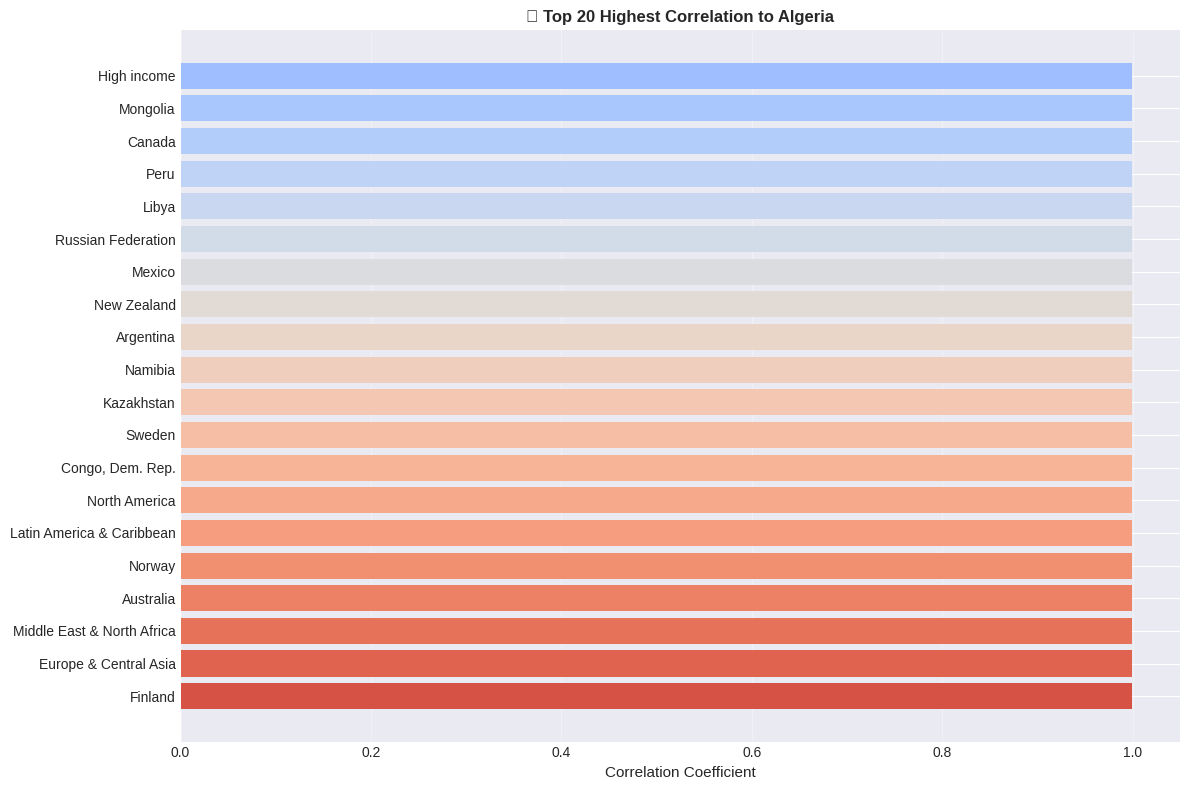

In [9]:

correlations = {}
for idx, row in df_processed.iterrows():
    if row['Country'] != 'Algeria':
        country_numeric = row.drop('Country')
        valid = ~(algeria_numeric.isna() | country_numeric.isna())
        if valid.sum() > 10:
            try:
                algeria_vals = algeria_numeric[valid].astype(float).values.flatten()
                country_vals = country_numeric[valid].astype(float).values.flatten()
                corr_value, _ = pearsonr(algeria_vals, country_vals)
                if not np.isnan(corr_value):
                    correlations[row['Country']] = corr_value
            except:
                pass

corr_df = pd.DataFrame(list(correlations.items()), 
                       columns=['Country', 'Correlation']).sort_values('Correlation', ascending=False)

print(f"\n🔗 TOP 15 COUNTRIES WITH HIGHEST CORRELATION:")
if len(corr_df) > 0:
    print(corr_df.head(15).to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(12, 8))
    top_20 = corr_df.head(20)
    colors = plt.cm.coolwarm(np.linspace(0.3, 0.9, len(top_20)))
    ax.barh(range(len(top_20)), top_20['Correlation'], color=colors)
    ax.set_yticks(range(len(top_20)))
    ax.set_yticklabels(top_20['Country'], fontsize=10)
    ax.set_xlabel('Correlation Coefficient', fontsize=11)
    ax.set_title('🔗 Top 20 Highest Correlation to Algeria', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
else:
    print("⚠️ Warning: No valid correlations calculated")

# TECHNIQUE 7: TOPSIS ANALYSIS


📊 Using 4 indicators for TOPSIS:
   • Population_millions_2024
   • Energy_Energy use_per capita_kilograms of oil equivalent_2015
   • Labor_Labor force participation rate_Male_% ages 15 and older_2021
   • Edu_Completion_Adult literacy rate_Male_% ages 15 and older_2016-23

🏅 TOP 15 COUNTRIES BY TOPSIS SCORE:
             Country  TOPSIS_Score
               World      0.723522
 Lower middle income      0.344148
 Upper middle income      0.320347
             Iceland      0.301993
               Qatar      0.297904
             Curacao      0.279351
 East Asia & Pacific      0.276881
 Trinidad and Tobago      0.263892
             Bahrain      0.213574
United Arab Emirates      0.210942
              Kuwait      0.202892
         High income      0.200152
          South Asia      0.195938
               China      0.177591
               India      0.173420

🇩🇿 ALGERIA'S TOPSIS RANKING:
   Rank: 3 out of 232
   TOPSIS Score: 0.0643
   Percentile: 98.7%


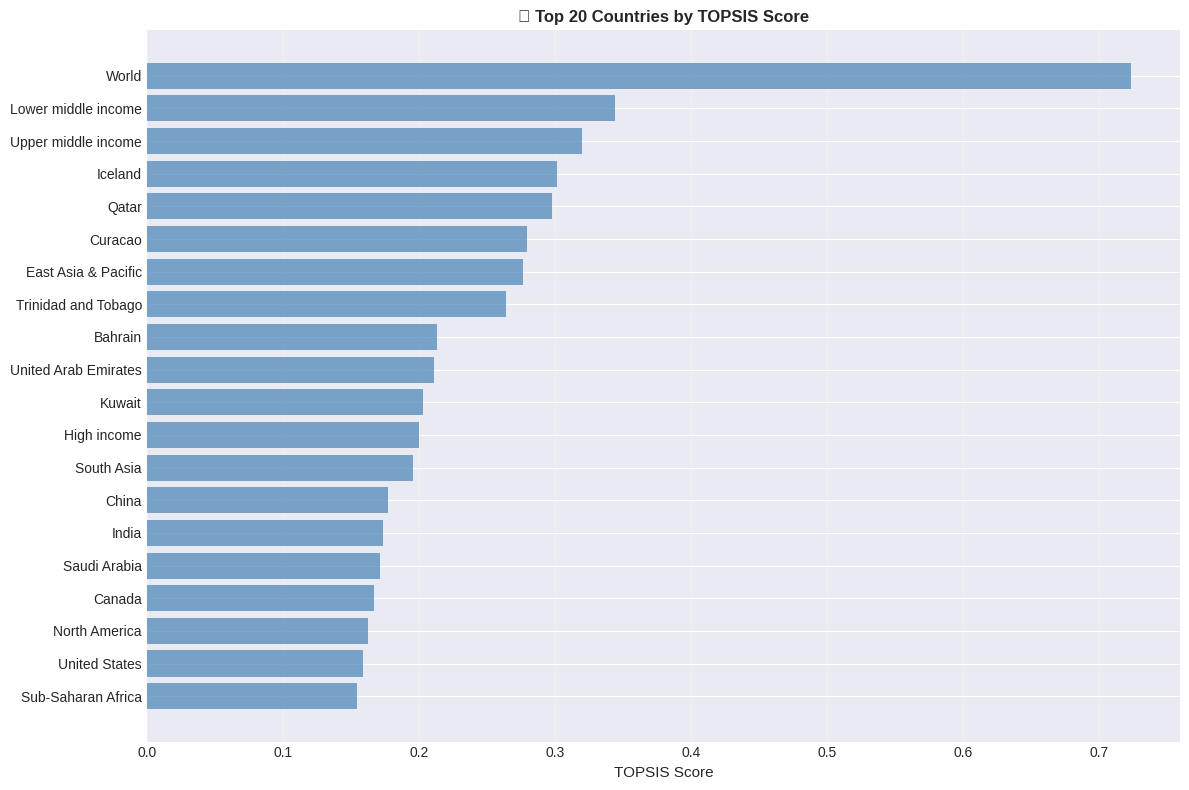

In [10]:

topsis_indicators = [
    'Population_millions_2024',
    'Energy_Energy use_per capita_kilograms of oil equivalent_2015',
    'Labor_Labor force participation rate_Male_% ages 15 and older_2021',
    'Edu_Completion_Adult literacy rate_Male_% ages 15 and older_2016-23'
]
available_topsis = [col for col in topsis_indicators if col in df_processed.columns]
print(f"\n📊 Using {len(available_topsis)} indicators for TOPSIS:")
for ind in available_topsis:
    print(f"   • {ind}")

if len(available_topsis) > 0:
    topsis_data = df_processed[['Country'] + available_topsis].copy()
    topsis_data[available_topsis] = topsis_data[available_topsis].fillna(
        topsis_data[available_topsis].median())
    
    # Normalize
    normalized = topsis_data[available_topsis].values / np.sqrt(
        (topsis_data[available_topsis].values**2).sum(axis=0))
    
    # Ideal solutions
    ideal_best = normalized.max(axis=0)
    ideal_worst = normalized.min(axis=0)
    
    # Calculate distances
    distance_to_best = np.sqrt(((normalized - ideal_best)**2).sum(axis=1))
    distance_to_worst = np.sqrt(((normalized - ideal_worst)**2).sum(axis=1))
    
    # TOPSIS score
    topsis_score = distance_to_worst / (distance_to_best + distance_to_worst)
    
    topsis_results = pd.DataFrame({
        'Country': topsis_data['Country'],
        'TOPSIS_Score': topsis_score
    }).sort_values('TOPSIS_Score', ascending=False)
    
    print(f"\n🏅 TOP 15 COUNTRIES BY TOPSIS SCORE:")
    print(topsis_results.head(15).to_string(index=False))
    
    algeria_rank = topsis_results[topsis_results['Country'] == 'Algeria'].index[0] + 1
    algeria_score = topsis_results[topsis_results['Country'] == 'Algeria']['TOPSIS_Score'].values[0]
    print(f"\n🇩🇿 ALGERIA'S TOPSIS RANKING:")
    print(f"   Rank: {algeria_rank} out of {len(topsis_results)}")
    print(f"   TOPSIS Score: {algeria_score:.4f}")
    print(f"   Percentile: {((len(topsis_results) - algeria_rank) / len(topsis_results) * 100):.1f}%")
    
    # Visualization
    fig, ax = plt.subplots(figsize=(12, 8))
    top_20 = topsis_results.head(20)
    colors = ['red' if c == 'Algeria' else 'steelblue' for c in top_20['Country']]
    ax.barh(range(len(top_20)), top_20['TOPSIS_Score'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(top_20)))
    ax.set_yticklabels(top_20['Country'], fontsize=10)
    ax.set_xlabel('TOPSIS Score', fontsize=11)
    ax.set_title('🏅 Top 20 Countries by TOPSIS Score', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
else:
    print("⚠️ No TOPSIS indicators available")
    topsis_results = pd.DataFrame(columns=['Country', 'TOPSIS_Score'])


# COMPREHENSIVE SUMMARY

In [11]:
# Start with Euclidean as base
summary = pd.DataFrame({'Country': euclidean_df['Country']})
summary['Euclidean_Rank'] = range(1, len(euclidean_df) + 1)

# Merge Cosine
if len(cosine_df) > 0:
    cosine_ranks = cosine_df.reset_index(drop=True).copy()
    cosine_ranks['Cosine_Rank'] = range(1, len(cosine_ranks) + 1)
    summary = summary.merge(cosine_ranks[['Country', 'Cosine_Rank']], 
                           on='Country', how='left')
else:
    summary['Cosine_Rank'] = np.nan

# Merge Correlation
if len(corr_df) > 0:
    corr_ranks = corr_df.reset_index(drop=True).copy()
    corr_ranks['Correlation_Rank'] = range(1, len(corr_ranks) + 1)
    summary = summary.merge(corr_ranks[['Country', 'Correlation_Rank']], 
                           on='Country', how='left')
else:
    summary['Correlation_Rank'] = np.nan

# Merge TOPSIS
if len(topsis_results) > 0:
    topsis_ranks = topsis_results.reset_index(drop=True).copy()
    topsis_ranks['TOPSIS_Rank'] = range(1, len(topsis_ranks) + 1)
    summary = summary.merge(topsis_ranks[['Country', 'TOPSIS_Rank']], 
                           on='Country', how='left')
else:
    summary['TOPSIS_Rank'] = np.nan

# Calculate average rank
summary['Average_Rank'] = summary[['Euclidean_Rank', 'Cosine_Rank', 
                                    'Correlation_Rank', 'TOPSIS_Rank']].mean(axis=1)
summary = summary.sort_values('Average_Rank')

print(f"\n🌟 TOP 20 MOST SIMILAR COUNTRIES TO ALGERIA (Combined Ranking):")
print(summary.head(20).to_string(index=False))


# Summary statistics
print(f"\n📈 SUMMARY STATISTICS:")
print(f"   • Total countries analyzed: {len(summary)}")
print(f"   • Countries with complete rankings: {summary[['Euclidean_Rank', 'Cosine_Rank', 'Correlation_Rank', 'TOPSIS_Rank']].notna().all(axis=1).sum()}")
print(f"   • Techniques applied: 7")
print(f"   • Visualizations generated: 7")
print("✅ ANALYSIS COMPLETE!")


🌟 TOP 20 MOST SIMILAR COUNTRIES TO ALGERIA (Combined Ranking):
                                          Country  Euclidean_Rank  Cosine_Rank  Correlation_Rank  TOPSIS_Rank  Average_Rank
                                             Oman               8            6                41           23         19.50
                                            Libya              28            8                 5           46         21.75
                               Iran, Islamic Rep.               1            1                55           53         27.50
                                           Mexico              11           30                 7           65         28.25
                                        Argentina              17           22                 9           67         28.75
                                     Saudi Arabia              97            9                27           16         37.25
Middle East, North Africa, Afghanistan & Pakistan               9   